# [CNN을 이용한 이미지 분류 실습]

### CNN 내부의 연산방법 : 합성곱 (Convolution)

<div style="display: flex; flex-direction: row;">
    <img src="./이미지모음/합성곱_그림설명.jpg" alt="이미지 1" width="400" height="200">
    <img src="./이미지모음/합성곱_그림설명2.jpg" alt="이미지 2" width="400" height="200">
</div>

## BasicBlock (합성곱) 모델 정의
- 2D 데이터에 대한 Convolution(합성곱) 모듈 사용 : Conv2d
- 합성곱 모델의 기본적 사용법인 : (합성곱 -> 활성화함수 -> 맥스풀링) 시행.
    1. 합성곱에서는 kernel_size를 3으로 설정하여 3*3 씩 확인하며 이동한다
    2. padding을 1로 설정하면 가로 1줄(위아래 한줄씩) + 세로 1줄(좌우 한줄씩) 추가되어 4*4의 이미지를 6*6의 형태로 만든다.
        1) 3*3 커널로 확인하면 입력 사이즈 그대로 출력된다. (출력 사이즈 4*4)
        2) 입력사이즈와 출력사이즈를 동일하게 유지함으로써 Layer를 거칠때마다 줄어드는 차원손실을 방지하여 feature 손실을 방지한다.
        3) 모델의 복잡성과 학습 가능한 매개변수의 수를 증가시켜 모델의 표현능력을 향상시켜 간접적으로 정확도 향상을 야기한다.
        4) stride 옵션은 kenel이 이동하는 칸 수를 뜻하며 default:1 이다.
    3. MaxPooling으로 feature 중 가장 큰 값을 추출한다. (가장 큰 특성 추출)
    
    
<div style="display: flex; flex-direction: row;">
    <img src="./이미지모음/CNN_Basic1.jpg" alt="이미지 2" width="450" height="200">
    <img src="./이미지모음/맥스풀링.jpg" alt="이미지 1" width="450" height="200">
</div>  

In [1]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, hidden_dim):
        super(BasicBlock, self).__init__()
        # nn.Module의 모든 것 상속받음
        
        self.conv1 = nn.Conv2d(in_ch, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_ch, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # kernel_size 가 3인경우 3x3의 픽셀에서 feature를 추출하며 이동한다.
        # stride 옵션은 커널이 한 번에 이동하는 간격을 뜻하며 default 1이다.
        
        # in_ch : 입력 채널 수
        # out_ch : 출력 채널 수
        # hiddin_dim : in_ch -> ?? -> out_ch 이 과정을 거칠 때 ?? 의 출력 갯수.
        # 1. (in_ch, hidden_dim) -> 2. (hidden_dim, hidden_dim) -> 3. (hidden_dim, out_ch) 예를 들면 이런식으로 입력 출력 갯수 설정
        
        # stride는 커널의 이동 거리
        
    def forward(self, x): 
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # pytorch는 연산 진행시 자동으로 forward 함수를 호출한다
        # cnn basic : 합성곱 -> 활성화 함수 -> max pooling (차원 감소 + 특징 추출 => 과적합 방지까지 함께 이뤄짐)
        
        return x

<div style="display: flex; flex-direction: row;">
    <img src="./이미지모음/CNN_최종.jpg" alt="이미지 1" width="450" height="200">
    <img src="./이미지모음/CNN_루프.jpg" alt="이미지 2" width="450" height="200">
</div>  

In [2]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.block1 = BasicBlock(in_ch=3, out_ch=32, hidden_dim=16)
        self.block2 = BasicBlock(in_ch=32, out_ch=128, hidden_dim=64)
        self.block3 = BasicBlock(in_ch=128, out_ch=256, hidden_dim=128)
        # 합성곱 기본 블록 정의
        
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        # num_classes : 유추해야할 target num
        # fc1의 입력 feature가 4096인 이유는 4*4*256이 되기때문
        
        self.relu = nn.ReLU()
        
    def forward(self, x): # pytorch는 연산 진행시 자동으로 forward 함수를 호출한다
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x) # 출력 모양 : (-1, 256, 4, 4)
        x = torch.flatten(x, start_dim=1) # 2차원 맵을 1차원으로 펴준다. (MLP 모델의 연산에 사용하기위해)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

# 데이터 전처리
    - 이미지 정규화 : 색깔 편향 제거하여 모양 및 특징을 강조하고 학습 안정성을 증가시킨다
<div style="display: flex; flex-direction: row;">
    <img src="./이미지모음/이미지_정규화.jpg" alt="이미지 1" width="500" height="200">
</div>  

In [3]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
from torchvision import transforms

transforms = transforms.Compose([
    transforms.RandomCrop((32, 32), padding=4),
    transforms.RandomHorizontalFlip(p=0.5), # Y축 기준 좌우대칭
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
    # 정규화 : 동형분포, 정규분포를 따르도록 기본 설정되어있는데.
    # 안에 들어있는 값은 image net에서 나오는 값을 그대로 가져옴
])
# 32*32 크기의 영역을 랜덤하게 자르고 padding을 준다.
# y축 기준으로 대칭한다.
# Tensor type으로 변환한다.
# 이미지 정규화를 진행한다.
# 효과들이 적용된 list가 저장된다.

# Compose : 안에있는 전처리 기법들을 순서대로 시행하라.

# 데이터 로드 및 모델 정의

In [4]:
from torchvision.datasets import CIFAR10
import numpy as np

train_data = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN(num_classes=10)

model.to(device) # 정의한 모델을 GPU로 전달

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [5]:
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
# 학습률, 최적화함수 Adam 사용

# 100회 학습 시행
for epoch in range(100):
    for data, label in train_loader:
        optim.zero_grad() # 이전 학습에 대한 기울기 제거 (0으로 초기화)
        preds = model(data.to(device)) 
        # 이미지 값을 gpu로 전달하여 model에 돌린다.
        # 1set : 합성곱-relu-합성곱-relu-맥스풀링
        # 1set - 1set - 1set - flatten (flatten : 이미지값을 1차원 데이터로 만들어주며 MLP 모델에서 연산 가능하게 만들어준다.)
        # MLP 시행 : Linear - Linear - Linear - relu -> 반환
        
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
        
    if epoch==0 or epoch%10==9:
        print(f'epoch{epoch+1} loss:{loss.item():.3f}')
              
              
torch.save(model.state_dict(), 'CIFAR.pth')

epoch1 loss:1.493
epoch10 loss:0.531
epoch20 loss:0.453
epoch30 loss:0.356
epoch40 loss:0.269
epoch50 loss:0.360
epoch60 loss:0.099
epoch70 loss:0.272
epoch80 loss:0.394
epoch90 loss:0.744
epoch100 loss:0.591


In [7]:
model.load_state_dict(torch.load('CIFAR.pth', map_location=device))

num_corr = 0
incorr_img_list = []

# 이미지를 PyTorch Tensor로 가져옴
image_tensor, label = test_data[0]
# 이미지 Tensor를 NumPy 배열로 변환
image = image_tensor.numpy()
# 이미지의 크기 확인
image_shape = image.shape

with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        
        corr_list = preds.eq(label.to(device).data)
        corr = corr_list.sum().item()
        num_corr += corr
        
        for idx, corr_data in enumerate(corr_list):
            incorr_img_list.append({
                'incorr_idx' : corr_list[idx].item(),
                'incorr_img_data' : data[idx].cpu(),
                'answer_idx' : label[idx].item(),
            })
        
    print(f'정확도({num_corr}/{len(test_data)}) : {num_corr / len(test_data)}')

정확도(8260/10000) : 0.826


# 가장 마지막 오답 이미지 출력
#### CIFAR Image Data Set

<img src="./이미지모음/CIFAR_Set.jpg" alt="이미지 1" width="400" height="100">

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

오답 갯수 : 10000
오답 이미지 Head 12개 출력


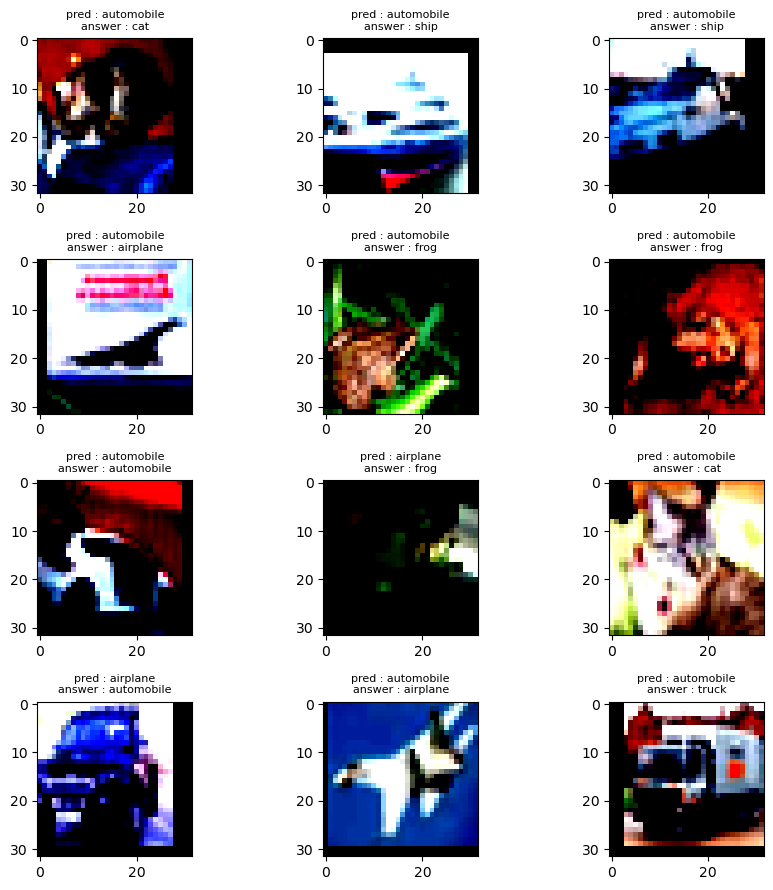

In [25]:
import matplotlib.pyplot as plt

aswer_features = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


print(f'오답 갯수 : {len(incorr_img_list)}')
print('오답 이미지 Head 12개 출력')
fig, axs = plt.subplots(figsize=(9, 9), nrows=4, ncols=3, tight_layout=True)

for idx in range(12):
    row = idx // 3 
    col = idx % 3
    
    image = incorr_img_list[idx]['incorr_img_data'].numpy()
    image = image.transpose(1, 2, 0)  # 채널 차원을 맨 뒤로 이동

    predict_name = aswer_features[incorr_img_list[idx]['incorr_idx']]
    answer_name = aswer_features[incorr_img_list[idx]["answer_idx"]]
    
    axs[row, col].set_title(f'pred : {predict_name}\nanswer : {answer_name}', fontsize=8)
    axs[row, col].imshow(image) 

plt.show()